In [1]:
import numpy as np 
import pickle
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# get residuals
avg_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-avg.p"
avg_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-avg.p"

max_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-max.p"
max_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-max.p"

min_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-min.p"
min_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-min.p"

last_residual_file_layer1 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer1-last.p"
last_residual_file_layer2 = "../final_residuals/concatenated-all-residuals-parallel-english-to-spanish-model-2layer-brnn-pred-layer2-last.p"

# open files
avg_residual_layer1 = pickle.load( open( avg_residual_file_layer1, "rb" ) )
avg_residual_layer2 = pickle.load( open( avg_residual_file_layer2, "rb" ) )

max_residual_layer1 = pickle.load( open( max_residual_file_layer1, "rb" ) )
max_residual_layer2 = pickle.load( open( max_residual_file_layer2, "rb" ) )

min_residual_layer1 = pickle.load( open( min_residual_file_layer1, "rb" ) )
min_residual_layer2 = pickle.load( open( min_residual_file_layer2, "rb" ) )

last_residual_layer1 = pickle.load( open( last_residual_file_layer1, "rb" ) )
last_residual_layer2 = pickle.load( open( last_residual_file_layer2, "rb" ) )

In [3]:
def clean_roi(roi_vals, roi_labels):
    roi_vals = roi_vals.reshape((len(roi_vals), ))
    final_roi_labels = []
    for val_index in roi_vals:
        if val_index == 0:
            final_roi_labels.append("other")
        else:
            final_roi_labels.append(roi_labels[val_index-1][0][0])
    return final_roi_labels

def clean_atlas(atlas_vals, atlas_labels):
    at_vals = atlas_vals.reshape((len(atlas_vals), ))
    at_labels = []
    for val_index in at_vals:
        at_labels.append(atlas_labels[val_index-1][0][0])
    return at_labels

In [4]:
# get atlas and roi
atlas_vals = pickle.load( open( "atlas_vals.p", "rb" ) )
atlas_labels = pickle.load( open( "atlas_labels.p", "rb" ) )
roi_vals = pickle.load( open( "roi_vals.p", "rb" ) )
roi_labels = pickle.load( open( "roi_labels.p", "rb" ) )

final_roi_labels = clean_roi(roi_vals, roi_labels)
at_labels = clean_atlas(atlas_vals, atlas_labels)

In [5]:
# get activations
activations = pickle.load( open( "activations.p", "rb" ) )
modified_activations = pickle.load( open( "modified_activations.p", "rb" ) )

In [6]:
df_dict = {'voxel_index': list(range(len(at_labels))) * 8, 
            'residuals': avg_residual_layer1 + avg_residual_layer2 + max_residual_layer1 + max_residual_layer2 + min_residual_layer1 + min_residual_layer2 + last_residual_layer1 + last_residual_layer2, 
            'atlas_labels': at_labels * 8, 
            'roi_labels': final_roi_labels * 8,
            'agg_type': ['avg']*len(at_labels)*2 + ['max']*len(at_labels)*2 + ['min']*len(at_labels)*2 + ['last']*len(at_labels)*2,
            'layer': (['layer1']*len(at_labels) + ['layer2']*len(at_labels))*4 }

df = pd.DataFrame(df_dict)

In [7]:
df.head()

,agg_type,atlas_labels,layer,residuals,roi_labels,voxel_index
0,avg,Cerebelum_8_L,layer1,5.530148e-12,other,0
1,avg,Cerebelum_7b_L,layer1,5.547563e-12,other,1
2,avg,Cerebelum_8_R,layer1,5.181878e-12,other,2
3,avg,Cerebelum_8_L,layer1,5.271514e-12,other,3
4,avg,Cerebelum_8_L,layer1,5.446057e-12,other,4


In [8]:
pickle.dump( df, open( "subj1-2layer-4aggs.p", "wb" ) )

In [9]:
df.to_csv("subj1-2layer-4aggs.csv")

### Prepping for Permutation Testing

In [10]:
only_avg_layer1 = df[df['agg_type'] == 'avg'][df['layer'] == 'layer1']

/Users/christinejou/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [11]:
def get_shuffle(df):
    original = df[['atlas_labels','residuals']]
    permutate_values = original["residuals"].sample(frac=1)
    permutate = pd.DataFrame({'atlas_labels': original["atlas_labels"], 'residuals':list(permutate_values)})
    return original, permutate

In [12]:
def calculate_p_value(df1, df2):
    numerator = 0
    df1_values = list(df1["residuals"])
    df2_values = list(df2["residuals"])
    for i in range(len(df1_values)):
        if df1_values[i] < df2_values[i]:
            numerator += 1
    return numerator * 1.0 / len(df1_values)

In [13]:
p_values = []
for _ in tqdm(range(1000)):
    original, permutate = get_shuffle(only_avg_layer1)
    p_val = calculate_p_value(permutate, original)
    p_values.append(p_val)

100%|██████████| 1000/1000 [01:23<00:00, 11.90it/s]


In [14]:
p_values

[0.500697534496552,
 0.4996594973784604,
 0.49938841762150654,
 0.49981156651041014,
 0.5007305930034975,
 0.4999504122395816,
 0.5008496036285017,
 0.5004595132465437,
 0.5012330823090706,
 0.49931568890622624,
 0.5002809973090375,
 0.49923634848955684,
 0.49989090692707955,
 0.500307444114594,
 0.5011272950868447,
 0.4997983431076319,
 0.4992627952951133,
 0.49914378467010917,
 0.49995702394097075,
 0.4986941889756491,
 0.4991966782812221,
 0.5008363802257235,
 0.5008826621354473,
 0.5010215078646189,
 0.5009487791493386,
 0.49891237512149,
 0.4999834707465272,
 0.499190066579833,
 0.5000561994618075,
 0.5012396940104598,
 0.5003008324132049,
 0.5003735611284852,
 0.4996528856770713,
 0.499414864427063,
 0.5006314174826608,
 0.500366949427096,
 0.4994809814409542,
 0.5002016568923681,
 0.4995470984548454,
 0.49887270491315533,
 0.5006776993923846,
 0.5004132313368199,
 0.5000429760590293,
 0.5002281036979246,
 0.5010479546701753,
 0.5001090930729205,
 0.500532241961824,
 0.4990313857

### Checking for certain brain region

In [15]:
original_cerebelum = original[original["atlas_labels"] == "Cerebelum_8_L"]
permutate_cerebelum = permutate[permutate["atlas_labels"] == "Cerebelum_8_L"]

In [16]:
calculate_p_value(original_cerebelum, permutate_cerebelum)

0.9718969555035128

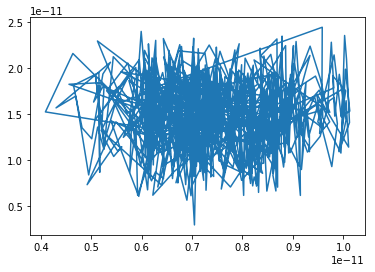

In [17]:
plt.plot(original_cerebelum["residuals"], permutate_cerebelum["residuals"])
plt.show()

In [18]:
original_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,5.530148e-12
3,Cerebelum_8_L,5.271514e-12
4,Cerebelum_8_L,5.446057e-12
5,Cerebelum_8_L,5.606933e-12
6,Cerebelum_8_L,5.526162e-12


In [19]:
permutate_cerebelum.head()

,atlas_labels,residuals
0,Cerebelum_8_L,1.709935e-11
3,Cerebelum_8_L,1.220875e-11
4,Cerebelum_8_L,1.037339e-11
5,Cerebelum_8_L,1.142612e-11
6,Cerebelum_8_L,1.097316e-11


### General Brain Areas

Original

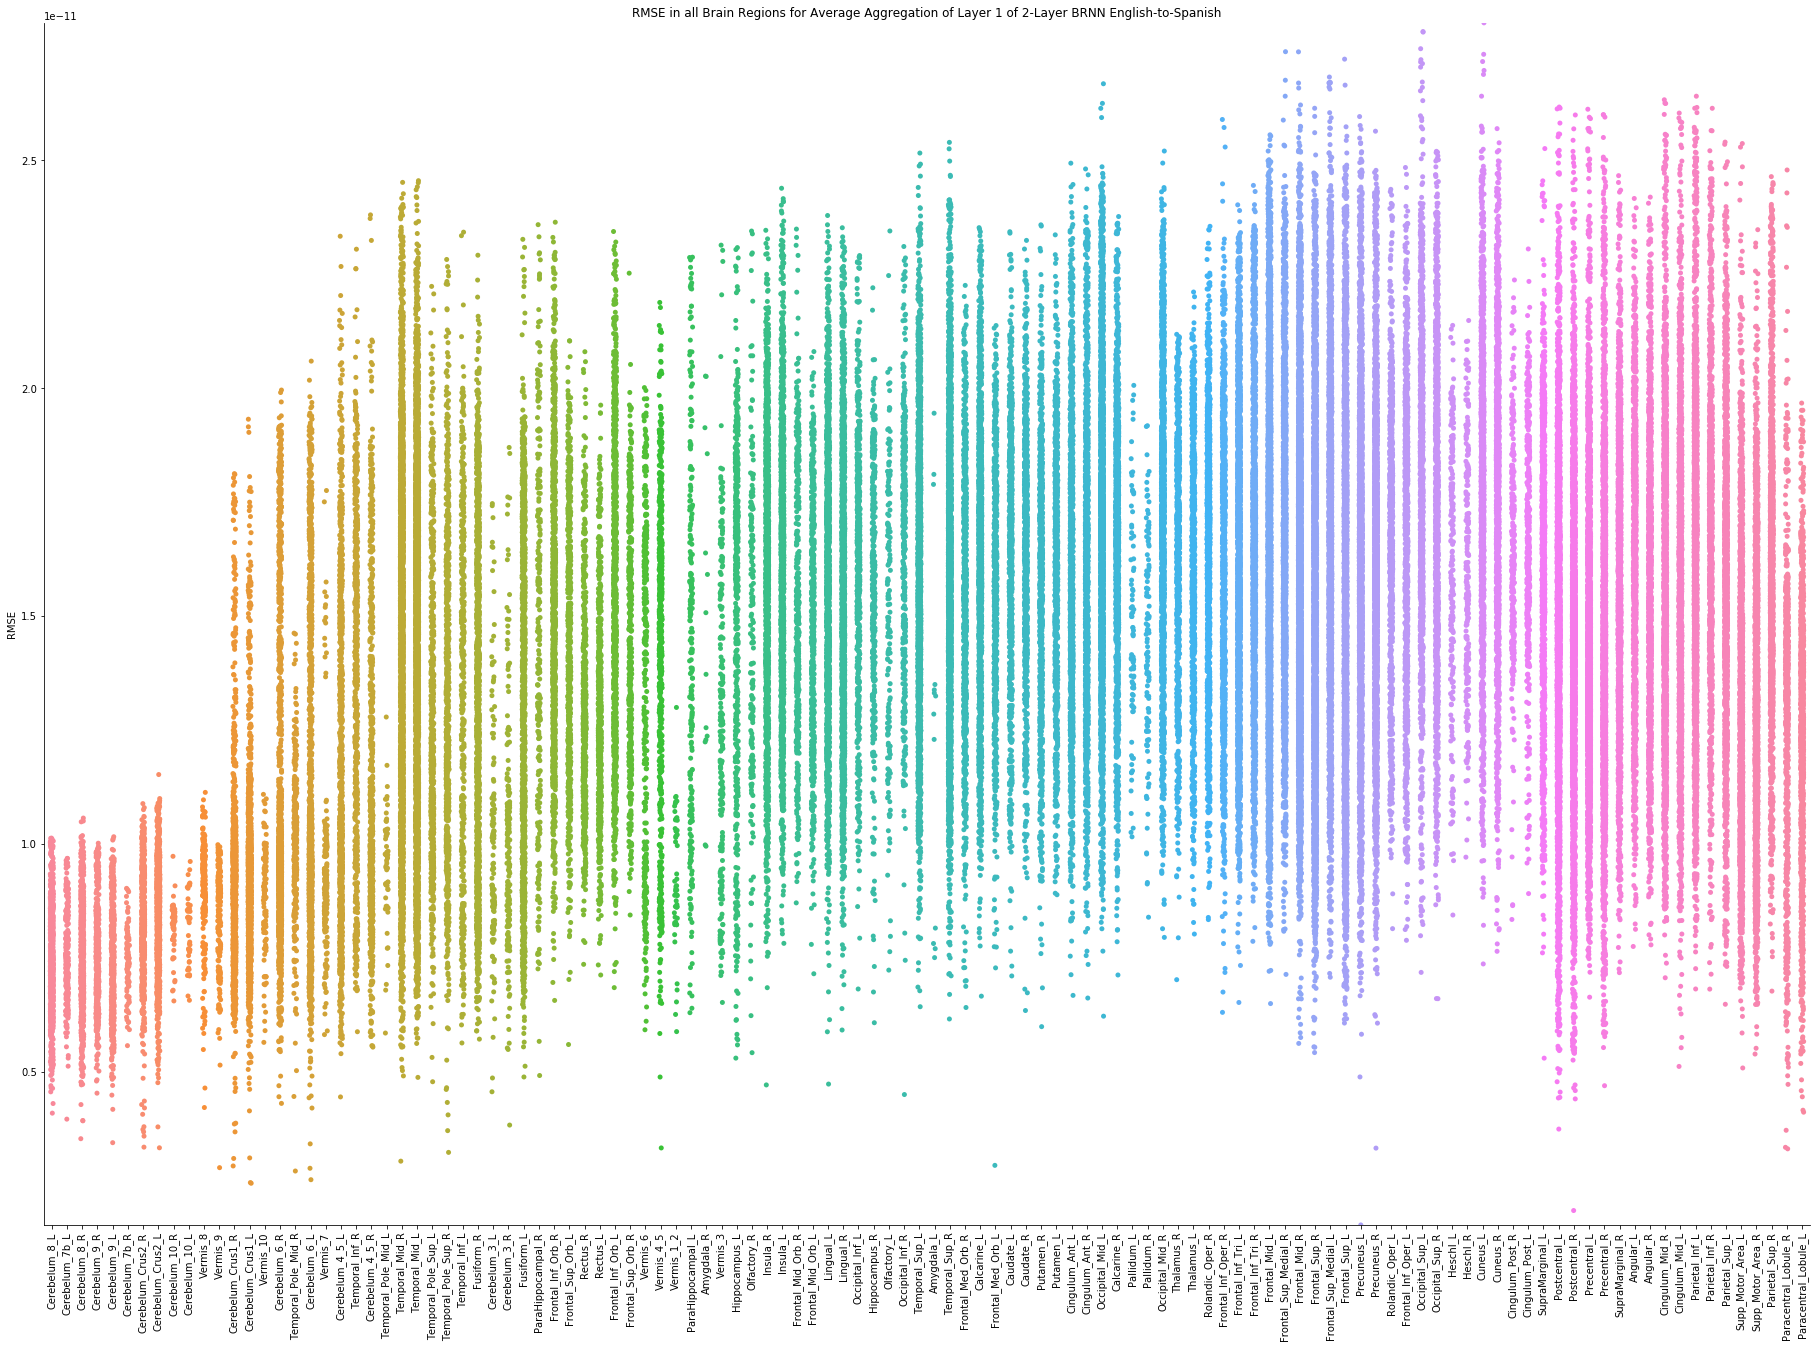

In [20]:
g = sns.catplot(x="atlas_labels", y="residuals", data=original, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(original["residuals"]), max(original["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish")
plt.show()

Scrambled

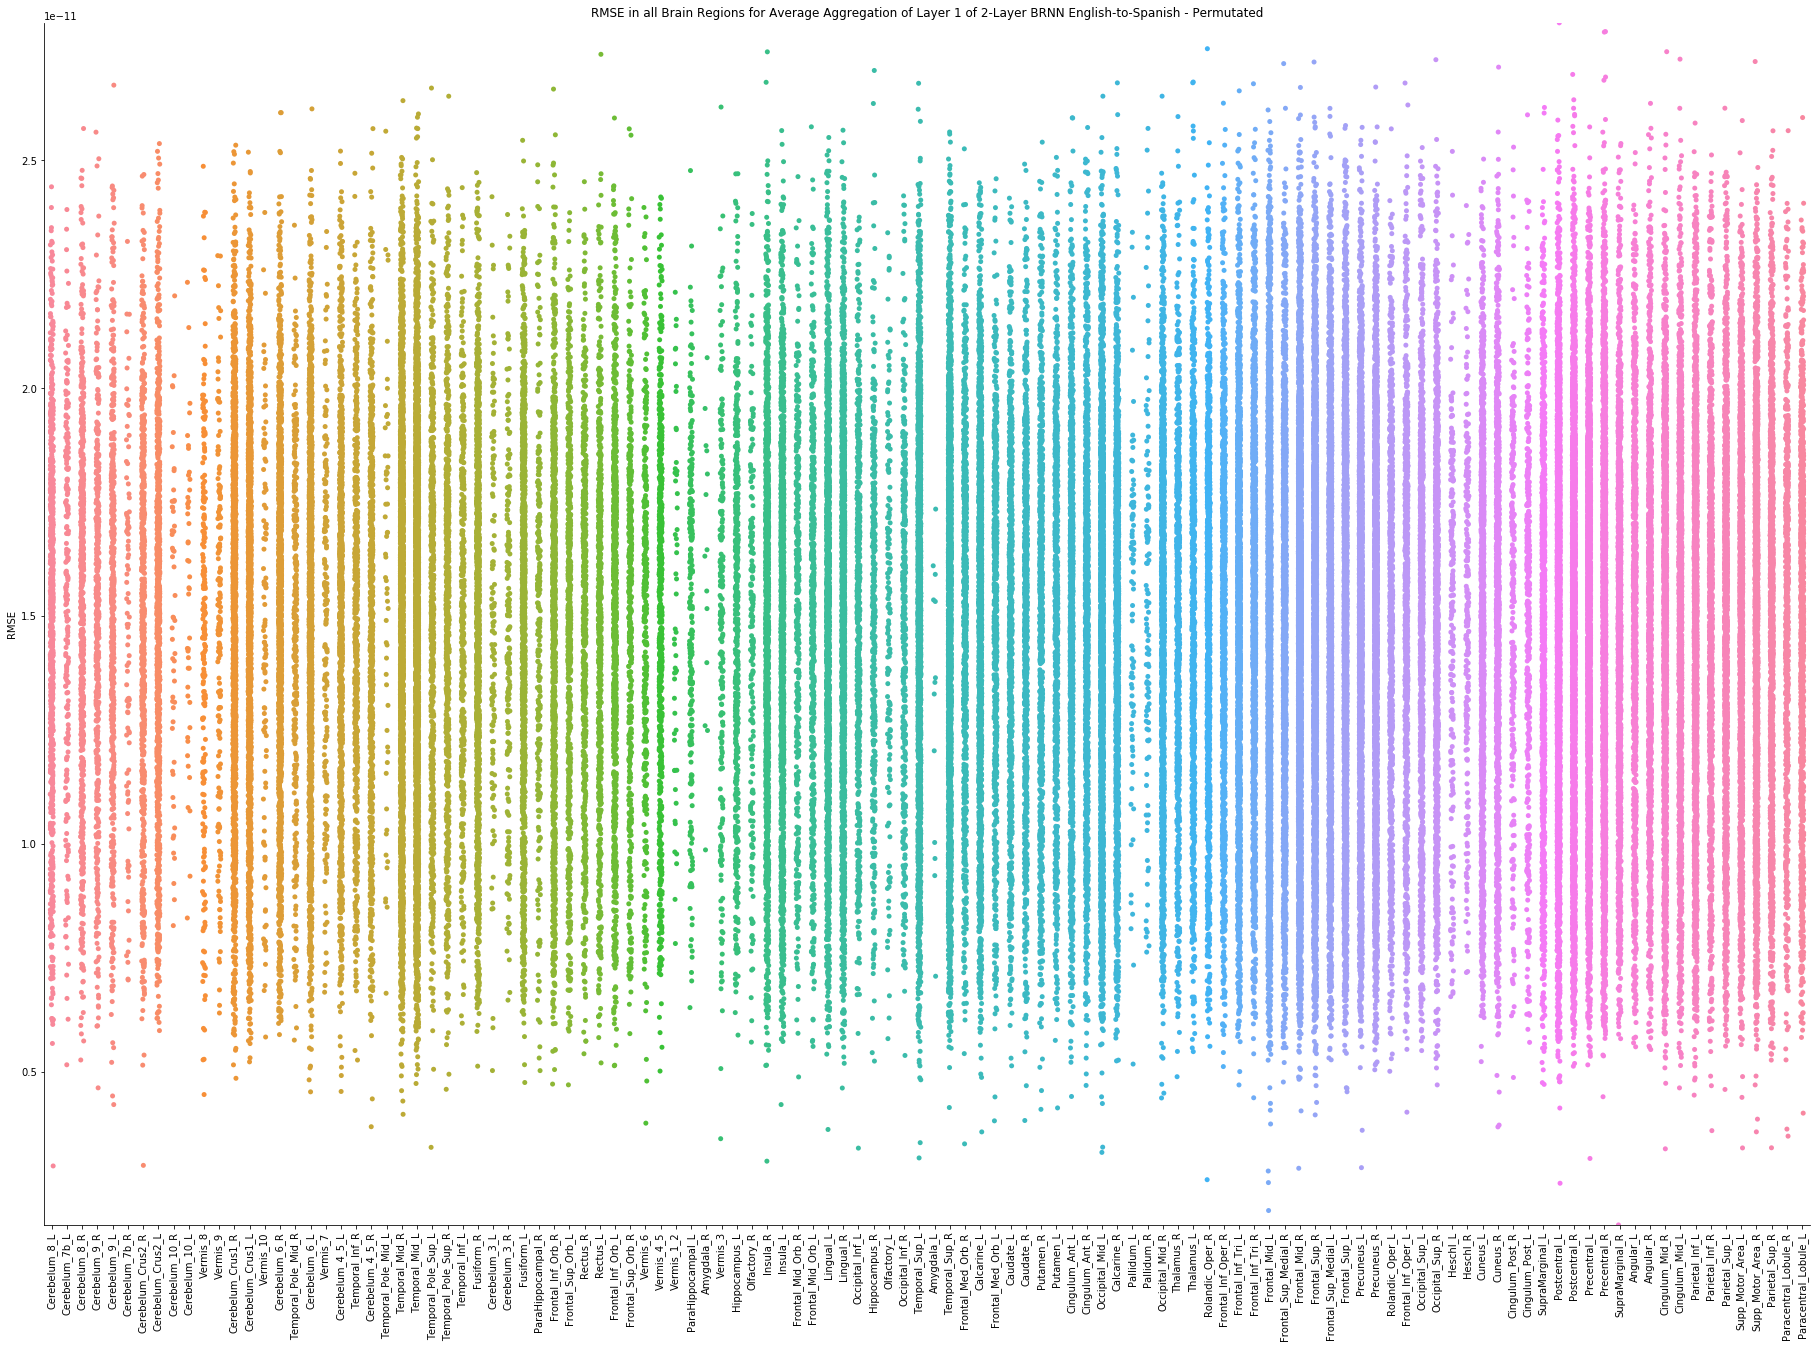

In [21]:
g = sns.catplot(x="atlas_labels", y="residuals", data=permutate, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(min(permutate["residuals"]), max(permutate["residuals"])))
g.set_axis_labels("", "RMSE")
plt.title("RMSE in all Brain Regions for Average Aggregation of Layer 1 of 2-Layer BRNN English-to-Spanish - Permutated")
plt.show()

In [22]:
all_atlas_labels = list(set(list(original["atlas_labels"])))

In [23]:
all_atlas_labels

['Frontal_Inf_Oper_L',
 'Cingulum_Post_L',
 'Amygdala_R',
 'Vermis_3',
 'SupraMarginal_L',
 'Cerebelum_8_R',
 'Vermis_7',
 'Fusiform_R',
 'Frontal_Sup_R',
 'Cerebelum_9_L',
 'Angular_R',
 'Frontal_Mid_Orb_L',
 'Pallidum_R',
 'Temporal_Sup_L',
 'Frontal_Sup_Orb_R',
 'Parietal_Inf_R',
 'Temporal_Mid_L',
 'Vermis_4_5',
 'Olfactory_L',
 'Precuneus_R',
 'Temporal_Pole_Sup_L',
 'Insula_R',
 'Occipital_Mid_R',
 'Parietal_Inf_L',
 'Vermis_6',
 'Occipital_Sup_R',
 'Vermis_9',
 'Cerebelum_Crus1_R',
 'Olfactory_R',
 'Angular_L',
 'Occipital_Inf_L',
 'Temporal_Pole_Mid_R',
 'Parietal_Sup_R',
 'Frontal_Mid_L',
 'Paracentral_Lobule_R',
 'Putamen_R',
 'Frontal_Inf_Tri_R',
 'Caudate_L',
 'Cerebelum_10_R',
 'Lingual_L',
 'Frontal_Med_Orb_L',
 'Pallidum_L',
 'Cingulum_Ant_L',
 'Cerebelum_7b_L',
 'Postcentral_R',
 'Vermis_10',
 'Occipital_Mid_L',
 'Temporal_Inf_L',
 'Cingulum_Mid_L',
 'Precentral_L',
 'Vermis_1_2',
 'Cerebelum_4_5_L',
 'Cerebelum_9_R',
 'Putamen_L',
 'Rolandic_Oper_R',
 'Parietal_Sup_L',

In [24]:
len(all_atlas_labels)

116

In [25]:
# p_values = []
# for _ in tqdm(range(200)):
#     original, permutate = get_shuffle(only_avg_layer1)
#     for atlas in all_atlas_labels:
#         original_sub = original[original['atlas_labels'] == atlas]
#         permutate_sub = permutate[permutate['atlas_labels'] == atlas]
#         p_val = calculate_p_value(permutate, original)
#         p_values.append(p_val)

In [26]:
p_values = {}
for _ in tqdm(range(1000)):
    original, permutate = get_shuffle(only_avg_layer1)
    for atlas in all_atlas_labels:
        original_sub = original[original['atlas_labels'] == atlas]
        permutate_sub = permutate[permutate['atlas_labels'] == atlas]
        p_val = calculate_p_value(permutate_sub, original_sub)
        if atlas not in p_values:
            p_values[atlas]=[p_val]
        else:
            p_values[atlas].append(p_val)

100%|██████████| 1000/1000 [1:08:27<00:00,  4.39s/it]


In [27]:
p_value_and_region = pd.DataFrame.from_dict(p_values)

In [28]:
len(p_values['Amygdala_L'])

1000

In [29]:
len(p_values['Frontal_Inf_Orb_L'])

1000

In [30]:
p_value_and_region.T.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Amygdala_L,0.384615,0.230769,0.461538,0.461538,0.230769,0.307692,0.307692,0.384615,0.307692,0.153846,...,0.461538,0.461538,0.384615,0.461538,0.307692,0.307692,0.230769,0.307692,0.461538,0.461538
Amygdala_R,0.571429,0.214286,0.428571,0.642857,0.428571,0.500000,0.428571,0.642857,0.357143,0.500000,...,0.357143,0.428571,0.357143,0.357143,0.571429,0.428571,0.428571,0.500000,0.500000,0.642857
Angular_L,0.570812,0.612263,0.597582,0.575130,0.586356,0.601036,0.576857,0.578584,0.582902,0.596718,...,0.593264,0.593264,0.602763,0.575130,0.626943,0.586356,0.600173,0.579447,0.582038,0.588946
Angular_R,0.582295,0.572459,0.590820,0.582295,0.556721,0.570492,0.578361,0.578361,0.566557,0.577049,...,0.588852,0.601967,0.580328,0.573770,0.576393,0.587541,0.573115,0.569180,0.549508,0.584918
Calcarine_L,0.621886,0.611627,0.628725,0.625794,0.624328,0.644358,0.632633,0.628236,0.626282,0.629213,...,0.619443,0.621886,0.616512,0.640449,0.633610,0.605276,0.624817,0.625794,0.619443,0.638984


In [31]:
unstacked_df = pd.DataFrame(p_value_and_region.T.unstack().reset_index())

In [32]:
unstacked_df.head()

,level_0,level_1,0
0,0,Amygdala_L,0.384615
1,0,Amygdala_R,0.571429
2,0,Angular_L,0.570812
3,0,Angular_R,0.582295
4,0,Calcarine_L,0.621886


In [33]:
unstack_p = {'trial': unstacked_df["level_0"], 
            'atlas': unstacked_df["level_1"], 
            'p_value': unstacked_df[0]
}

unstack_p_df = pd.DataFrame(unstack_p)

In [34]:
unstack_p_df.head()

,atlas,p_value,trial
0,Amygdala_L,0.384615,0
1,Amygdala_R,0.571429,0
2,Angular_L,0.570812,0
3,Angular_R,0.582295,0
4,Calcarine_L,0.621886,0


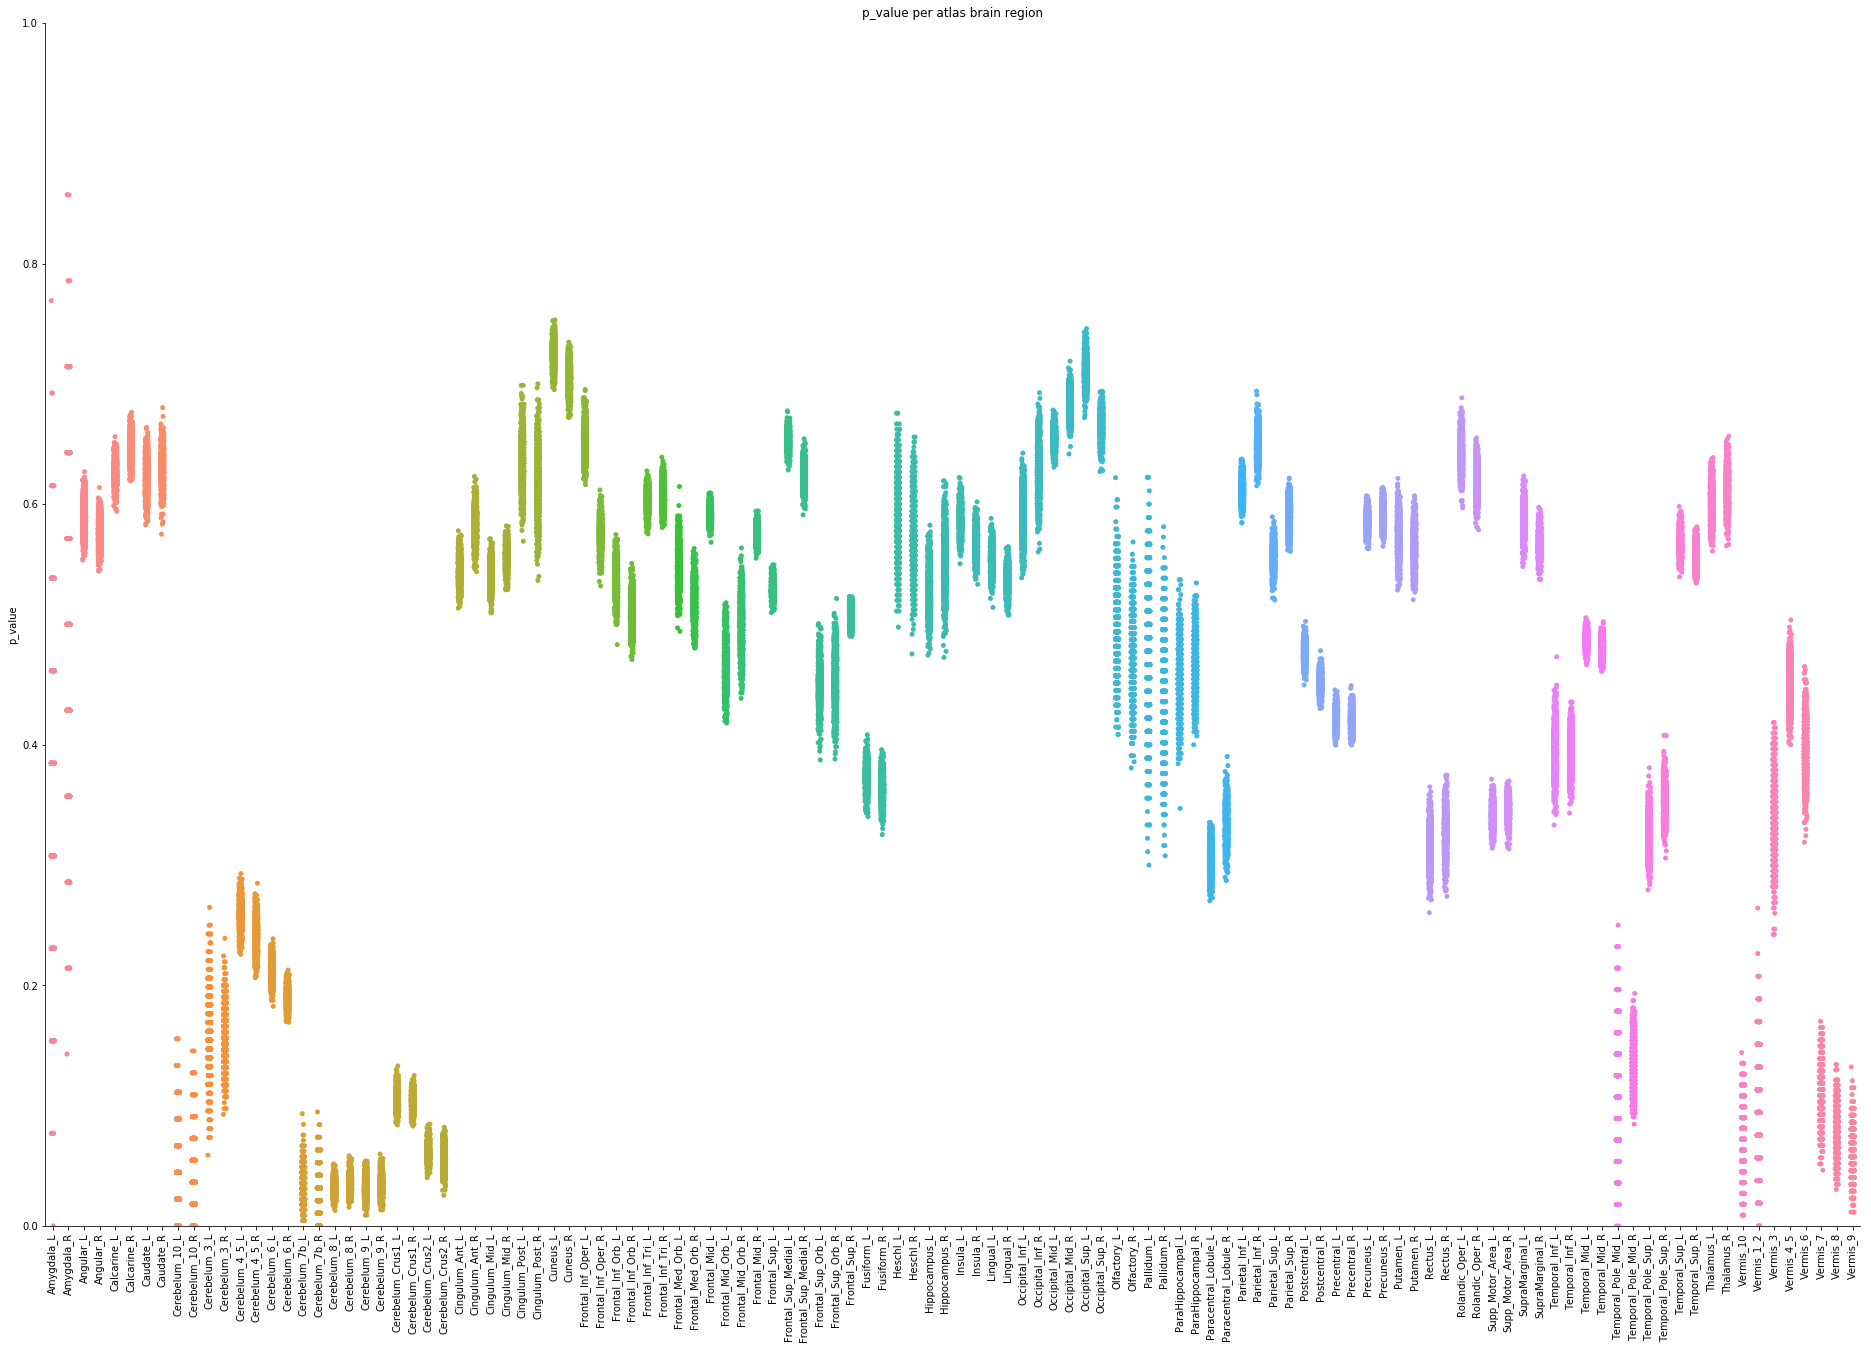

In [35]:
g = sns.catplot(x="atlas", y="p_value", data=unstack_p_df, height=17.5, aspect=1.5)
g.set_xticklabels(rotation=90)
g.set(ylim=(0, 1))
g.set_axis_labels("", "p_value")
plt.title("p_value per atlas brain region")
plt.show()

In [36]:
set(list(final_roi_labels))

{'LAngG',
 'LAntTemp',
 'LIFG',
 'LIFGorb',
 'LMFG',
 'LMidAntTemp',
 'LMidPostTemp',
 'LPostTemp',
 'other'}